In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect , select

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base=automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# # ** View all of the classes OPTION 2 WITH INSPECT ** 
inspector=inspect(engine).get_table_names()
inspector

['measurement', 'station']

In [11]:
# Save references to each table
table_me = Base.classes.measurement
table_st = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# <center> Exploratory Precipitation Analysis

> ## Precipitation Analysis

- Find the most recent date in the dataset.

- Using that date, get the previous 12 months of precipitation data by querying the previous 12 months of data.

- Select only the "date" and "prcp" values.

- Load the query results into a Pandas DataFrame. Explicitly set the column names.

- Sort the DataFrame values by "date".

- Plot the results by using the DataFrame plot method 

- Calculate the summary statistics for the precipitation data

In [10]:
# Find the most recent date in the data set.
most_recent_date= session.query(table_me.date).order_by(table_me.date.desc()).first()
print(f" The most recent date is: {most_recent_date}")

 The most recent date is: ('2017-08-23',)


In [11]:
# Checking a list of column names and types in measurement table
measurement_columns = inspect(engine).get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [15]:
# Testing the date one year from the last date in data set.
one_year_lastdate = dt.date(2017, 8, 23) - dt.timedelta(days=365) 
print(f" The date, one year from the last date is: {one_year_lastdate}")

 The date, one year from the last date is: 2016-08-23


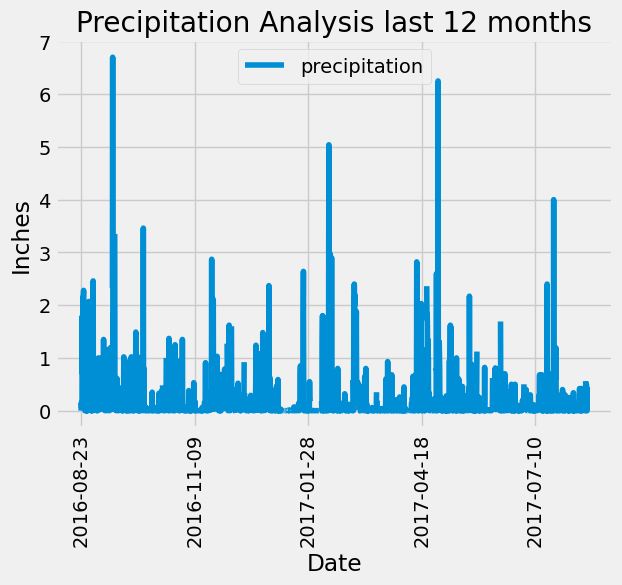

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_lastdate = dt.date(2017, 8, 23) - dt.timedelta(days=365) 

# Perform a query to retrieve the data and precipitation scores
prec_data = session.query(table_me.date, table_me.prcp).\
            filter(table_me.date >= one_year_lastdate).\
            order_by(table_me.date).all()

# Save the query results as a PANDAS DATAFRAME and set the index to the date column
prec_df = pd.DataFrame(prec_data, columns=["date", "precipitation"])

# Sort the dataframe by date
prec_df = prec_df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(x= "date", y= "precipitation", rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title ("Precipitation Analysis last 12 months")
plt.savefig("./Resources/Precipitation Analysis last 12 months")

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = prec_df.describe()
summary_statistics

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# <center> Exploratory Station Analysis

> ## Station Analysis

- Design a query to calculate the total number of stations in the dataset.

- Design a query to find the most-active stations (that is, the stations that have the most rows). To do so, complete the following steps:

    - List the stations and observation counts in descending order.
    - Answer the following question: which station id has the greatest number of observations?

`HINT
You’ll need to use the func.count function in your query.`

- Design a query that calculates the lowest, highest, and average temperatures that filters on the most-active station id found in the previous query.

`HINT
You’ll need to use functions such as func.min, func.max, and func.avg in your query.`

- Design a query to get the previous 12 months of temperature observation (TOBS) data. To do so, complete the following steps:

    - Filter by the station that has the greatest number of observations.

    - Query the previous 12 months of TOBS data for that station.

    - Plot the results as a histogram with bins=12, as the following image shows:


In [15]:
# Checking a list of column names and types
columns = inspect(engine).get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(table_st.station,)).all()
total_stations

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(table_me.station, func.count(table_me.station)).\
                       group_by(table_me.station).\
                       order_by(func.count(table_me.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# which station id has the greatest number of observations?
# Find most active station id
most_active_station_id = most_active_stations[0][0]
most_active_station_id

'USC00519281'

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lo,hi,avg= session.query(func.min(table_me.tobs),
                         func.max(table_me.tobs),
                         func.avg(table_me.tobs)).\
                         filter(table_me.station==most_active_station_id).first()
print(f'The Most active station ID is: {most_active_station_id}')
print(f'The Lowest Temperature  is:    {lo} F')
print(f'The Highest Temperature is:    {hi} F')
print(f'The Average Temperature is:    {avg:.2f} F')

The Most active station ID is: USC00519281
The Lowest Temperature  is:    54.0 F
The Highest Temperature is:    85.0 F
The Average Temperature is:    71.66 F


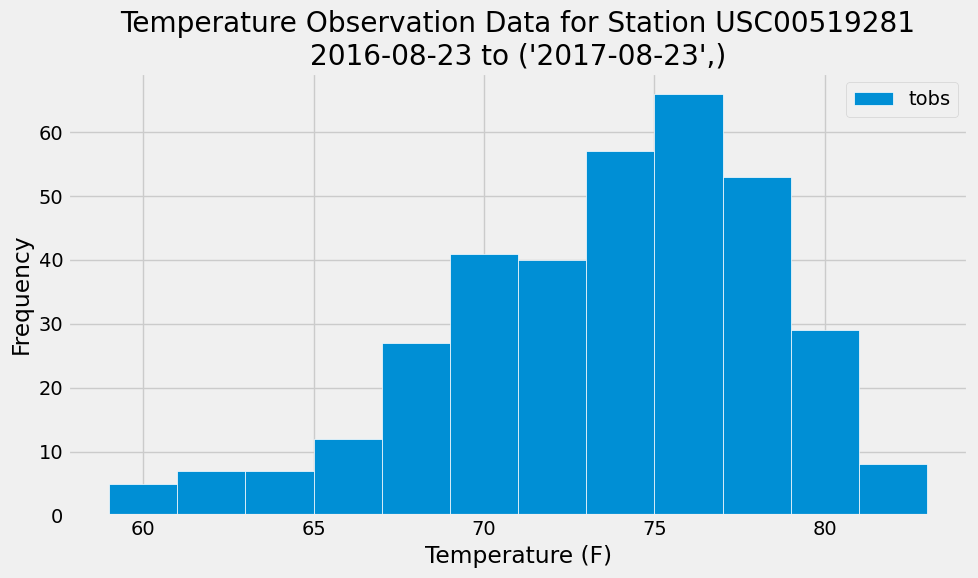

In [20]:
# Plot the results as a histogram with bins=12
tobs_data = session.query(table_me.tobs).\
            filter(table_me.station == most_active_station_id).\
            filter(table_me.date >= one_year_lastdate).all()

# Query results into a DATAFRAME
tobs_df = pd.DataFrame(tobs_data, columns=["tobs"])

# Plot the Dataframe into a histogram
tobs_df.plot.hist(edgecolor="white", bins=12, figsize=(10, 6))
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observation Data for Station {most_active_station_id}\n{one_year_lastdate} to {most_recent_date}")
plt.legend(["tobs"])
plt.savefig("./Resources/Temperature observation in the last 12 months")
plt.tight_layout()

# <CENTER> Close Session

In [21]:
# Close Session
session.close()